<a href="https://colab.research.google.com/github/rengo/MentoriaDiploDatos/blob/master/TP2_AnalisisYCuracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sb

df = pd.read_csv("https://raw.githubusercontent.com/sergiobuzzi/MentoriaDiplodatos2020/master/dataset.csv", index_col=0, parse_dates=True, dayfirst=True)
df.head()

,MERV,BVSP,GSPC,NDX,FTSE,GDAXI,FCHI,N225,HSI,SSEC,BSESN,DEXARUS,DEXBZUS,DEXUSUK,DEXUSEU,DEXJPUS,DEXHKUS,DEXCHUS,DEXINUS,DOLAR_BLUE
FECHA,,,,,,,,,,,,,,,,,,,,
1997-07-02,824.109985,13260.0,904.030029,975.929993,4751.399902,3867.530029,2909.500000,20196.41992,NaN,1199.06,4333.899902,0.9998,1.0767,1.6670,1.1223,114.52,7.7472,8.3210,35.80,NaN
1997-07-03,831.440002,13285.0,916.919983,986.520020,4831.700195,3939.729980,2937.000000,20121.41016,15055.70020,1150.62,4323.459961,0.9994,1.0778,1.6885,1.1242,113.46,7.7445,8.3214,35.79,NaN
1997-07-04,837.950012,13494.0,NaN,NaN,4812.799805,3946.729980,2934.500000,19968.00000,14823.00000,1159.34,4323.819824,0.9995,NaN,NaN,1.1230,NaN,NaN,NaN,NaN,NaN
1997-07-07,841.690002,13502.0,912.200012,991.039978,4810.700195,4003.350098,2947.699951,19705.16992,14858.59961,1096.82,4291.450195,0.9998,1.0779,1.6870,1.1226,112.60,7.7428,8.3218,35.82,NaN
1997-07-08,846.330017,13617.0,918.750000,1005.809998,4758.500000,4030.100098,2929.800049,19853.89063,14792.20020,1109.67,4306.390137,0.9999,1.0790,1.6885,1.1180,112.76,7.7436,8.3219,35.80,NaN


# Consignas del Trabajo Práctico N°2

#### **Tratamiento de faltantes:**
  

*   Eliminar los fines de semana.
*   Imputar los faltantes debidos a feriados usando un algoritmo adecuado para series temporales, por ejemplo splines..



In [ ]:
# Primero agregamos las columnas que indican, el año, mes y dia de la semana al que pertenece cada observación.

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday'] = df.index.day_name()

df.head()

,MERV,BVSP,GSPC,NDX,FTSE,GDAXI,FCHI,N225,HSI,SSEC,BSESN,DEXARUS,DEXBZUS,DEXUSUK,DEXUSEU,DEXJPUS,DEXHKUS,DEXCHUS,DEXINUS,DOLAR_BLUE,Year,Month,Weekday
FECHA,,,,,,,,,,,,,,,,,,,,,,,
1997-07-02,824.109985,13260.0,904.030029,975.929993,4751.399902,3867.530029,2909.500000,20196.41992,NaN,1199.06,4333.899902,0.9998,1.0767,1.6670,1.1223,114.52,7.7472,8.3210,35.80,NaN,1997,7,Wednesday
1997-07-03,831.440002,13285.0,916.919983,986.520020,4831.700195,3939.729980,2937.000000,20121.41016,15055.70020,1150.62,4323.459961,0.9994,1.0778,1.6885,1.1242,113.46,7.7445,8.3214,35.79,NaN,1997,7,Thursday
1997-07-04,837.950012,13494.0,NaN,NaN,4812.799805,3946.729980,2934.500000,19968.00000,14823.00000,1159.34,4323.819824,0.9995,NaN,NaN,1.1230,NaN,NaN,NaN,NaN,NaN,1997,7,Friday
1997-07-07,841.690002,13502.0,912.200012,991.039978,4810.700195,4003.350098,2947.699951,19705.16992,14858.59961,1096.82,4291.450195,0.9998,1.0779,1.6870,1.1226,112.60,7.7428,8.3218,35.82,NaN,1997,7,Monday
1997-07-08,846.330017,13617.0,918.750000,1005.809998,4758.500000,4030.100098,2929.800049,19853.89063,14792.20020,1109.67,4306.390137,0.9999,1.0790,1.6885,1.1180,112.76,7.7436,8.3219,35.80,NaN,1997,7,Tuesday


In [ ]:
# Eliminamos todas las observaciones pertenecientes a ls días Sábados o Domingos

df.drop(df[df.Weekday == 'Saturday'].index, inplace= True)
df.drop(df[df.Weekday == 'Sunday'].index, inplace= True)

# para verificar que se eliminaron todas las observaciones pertenecientes a sabado y domingo: 
sum(df.Weekday == 'Saturday') + sum(df.Weekday == 'Sunday')

#df


0

A continuación utilizamos el algoritmo spline para completar los valores faltantes correspondientes a feriados y demás. Este algoritmo es muy utilizado para el "suavizado" de curvas y es muy fácil de aplicar. Se decidió utilizar el algoritmo de orden 1 porque se puede interpretar a cada uno de las observaciones que sí tenemos como un polinomio o función de primer grado. La función resultante de aplicar este algoritmo pasa obligatoriamente por todos los puntos que ya tenemos, con lo que nos podemos quedar tranquilos que las columnas resultantes no tendrán ningun valor modificado, excepto por aquellos que eran NAs y que ahora serán una aproximación de los puntos por los que dicho valor faltante estaba rodeado. 

In [ ]:

df2 = df.interpolate(method='spline', order=1, limit_direction='both')
df2

,MERV,BVSP,GSPC,NDX,FTSE,GDAXI,FCHI,N225,HSI,SSEC,BSESN,DEXARUS,DEXBZUS,DEXUSUK,DEXUSEU,DEXJPUS,DEXHKUS,DEXCHUS,DEXINUS,DOLAR_BLUE,Year,Month,Weekday
FECHA,,,,,,,,,,,,,,,,,,,,,,,
1997-07-02,824.109985,13260.0,904.030029,975.929993,4751.399902,3867.530029,2909.500000,20196.419920,15288.12315,1199.060000,4333.899902,0.9998,1.076700,1.66700,1.1223,114.520000,7.747200,8.321000,35.800000,-36.140826,1997,7,Wednesday
1997-07-03,831.440002,13285.0,916.919983,986.520020,4831.700195,3939.729980,2937.000000,20121.410160,15055.70020,1150.620000,4323.459961,0.9994,1.077800,1.68850,1.1242,113.460000,7.744500,8.321400,35.790000,-36.133152,1997,7,Thursday
1997-07-04,837.950012,13494.0,915.711121,987.645566,4812.799805,3946.729980,2934.500000,19968.000000,14823.00000,1159.340000,4323.819824,0.9995,1.587887,1.74917,1.1230,113.515935,7.769796,8.562043,36.157468,-36.125478,1997,7,Friday
1997-07-07,841.690002,13502.0,912.200012,991.039978,4810.700195,4003.350098,2947.699951,19705.169920,14858.59961,1096.820000,4291.450195,0.9998,1.077900,1.68700,1.1226,112.600000,7.742800,8.321800,35.820000,-36.102457,1997,7,Monday
1997-07-08,846.330017,13617.0,918.750000,1005.809998,4758.500000,4030.100098,2929.800049,19853.890630,14792.20020,1109.670000,4306.390137,0.9999,1.079000,1.68850,1.1180,112.760000,7.743600,8.321900,35.800000,-36.094783,1997,7,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04,32387.279300,78876.0,2842.739990,8834.110352,5753.799805,10466.799810,4378.229980,19647.470067,23613.80078,2872.090026,31715.349610,66.8835,5.571400,1.24300,1.0908,106.820000,7.753200,7.062200,77.412524,110.000000,2020,5,Monday
2020-05-05,33546.519530,79471.0,2868.439941,8930.620117,5849.399902,10729.459960,4483.129883,19656.640522,23868.66016,2875.103367,31453.509770,66.9515,5.562300,1.24490,1.0840,106.520000,7.753400,7.062200,77.443228,110.000000,2020,5,Tuesday
2020-05-06,34158.890630,79064.0,2848.419922,8984.860352,5853.799805,10606.200200,4433.379883,19665.810977,24137.48047,2878.140000,31685.750000,67.0475,5.679800,1.23470,1.0795,106.070000,7.752000,7.103100,77.473932,112.000000,2020,5,Wednesday


In [ ]:
# Verificación de que ya no hay más NAs
df2.isnull().sum()

MERV          0
BVSP          0
GSPC          0
NDX           0
FTSE          0
GDAXI         0
FCHI          0
N225          0
HSI           0
SSEC          0
BSESN         0
DEXARUS       0
DEXBZUS       0
DEXUSUK       0
DEXUSEU       0
DEXJPUS       0
DEXHKUS       0
DEXCHUS       0
DEXINUS       0
DOLAR_BLUE    0
Year          0
Month         0
Weekday       0
dtype: int64

#### **Expresión en moneda común:**
*   Construir una serie corregida para el tipo de cambio de Argentina. Para ello se deberá sobreescribir las cotizaciones oficiales con los valores del _DOLARBLUE en los períodos de cepo cambiario, o sea 28/10/2011 - 16/12/2015 y 01/09/2019 - 08/05/2020. de la lista


In [ ]:
# Agregamos la columna DEXARUS_FIX con el valor corregido para los períodos mencionados

# 1-  Copiamos el valor de DEXARUS a la nueva columna DEXARUS_FIX
df2['DEXARUS_FIX'] = df2.DEXARUS

# 2- Sobreescribimos los valores con DOLAR_BLUE para el período 28/10/2011 a 16/12/2015
for index, row in df2.loc['2011-10-28':'2015-12-16'].iterrows():
  df2.loc[index, 'DEXARUS_FIX'] = row['DOLAR_BLUE']

# 3- Sobreescribimos los valores con DOLAR_BLUE para el período 01/09/2019 a 08/05/2020
for index, row in df2.loc['2015-12-16':'2020-05-08'].iterrows():
  df2.loc[index, 'DEXARUS_FIX'] = row['DOLAR_BLUE']

# test
# df2.loc['2011-10-28':'2015-12-16']

*   Expresar todos los índices en dólares estadounidenses.

In [ ]:
df_usd = df2.copy()

for index, row in df_usd.iterrows():
  df_usd.loc[index, 'MERV'] = row['MERV'] / row['DEXARUS_FIX']
  df_usd.loc[index, 'BVSP'] = row['BVSP'] / row['DEXBZUS']
  df_usd.loc[index, 'FTSE'] = row['FTSE'] * row['DEXUSUK']
  df_usd.loc[index, 'GDAXI'] = row['GDAXI'] * row['DEXUSEU']
  df_usd.loc[index, 'FCHI'] = row['FCHI'] * row['DEXUSEU']
  df_usd.loc[index, 'N225'] = row['N225'] / row['DEXJPUS']
  df_usd.loc[index, 'HSI'] = row['HSI'] / row['DEXHKUS']
  df_usd.loc[index, 'SSEC'] = row['SSEC'] / row['DEXCHUS']
  df_usd.loc[index, 'BSESN'] = row['BSESN'] / row['DEXINUS'] 

df_usd = df_usd.drop(['DEXARUS', 'DEXBZUS', 'DEXUSUK', 'DEXUSEU', 'DEXJPUS', 'DEXHKUS', 'DEXCHUS',	'DOLAR_BLUE', 'DEXARUS_FIX', 'DEXINUS'], axis=1)

# test
df_usd.loc['2019-01-01':'2019-05-01']


,MERV,BVSP,GSPC,NDX,FTSE,GDAXI,FCHI,N225,HSI,SSEC,BSESN,Year,Month,Weekday
FECHA,,,,,,,,,,,,,,
2019-01-01,623.587716,28002.274666,2508.013937,6344.952167,9735.333337,12123.804209,5399.427966,180.366497,3273.188430,397.757820,506.971996,2019,1,Tuesday
2019-01-02,626.443810,23873.252367,2510.030029,6360.870117,8483.745406,12001.110005,5319.175232,180.288936,3207.447302,359.387437,504.874378,2019,1,Wednesday
2019-01-03,625.424319,24463.384007,2447.889893,6147.129883,8454.888156,11868.742586,5254.331973,181.610813,3200.740586,358.671479,498.718030,2019,1,Thursday
2019-01-04,649.947686,24722.334383,2531.939941,6422.669922,8710.847475,12269.783245,5397.948373,180.644205,3271.171358,366.262762,497.980709,2019,1,Friday
2019-01-07,662.960760,24716.711590,2549.689941,6488.250000,8688.665005,12334.186263,5415.719402,184.486933,3297.556954,369.788762,503.301420,2019,1,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-25,556.728409,24360.287625,2926.169922,7816.919922,9590.732536,13672.989886,6186.798157,199.906623,3767.329294,463.352517,553.139951,2019,4,Thursday
2019-04-26,564.772962,24533.102200,2939.879883,7826.680176,9604.662852,13730.193836,6209.279311,199.450990,3774.560424,458.725959,553.204873,2019,4,Friday
2019-04-29,541.743254,24436.766424,2943.030029,7839.040039,9616.360932,13790.122646,6242.884206,198.277067,3811.302855,454.835739,555.340365,2019,4,Monday


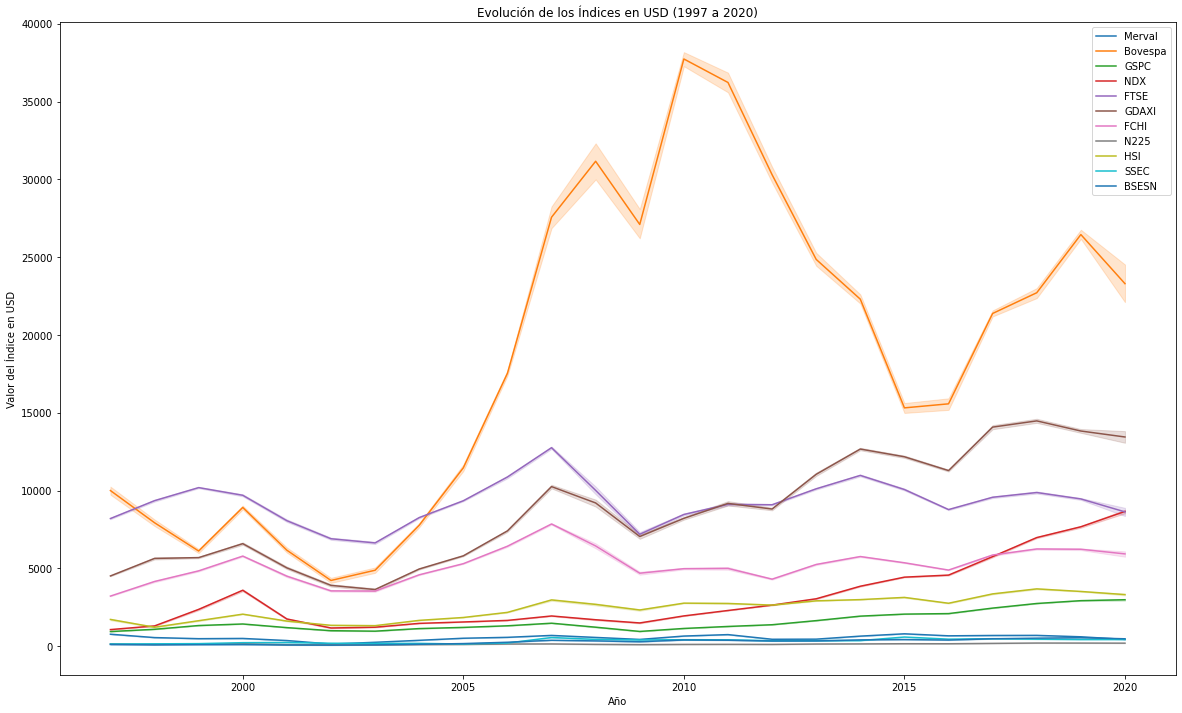

In [ ]:
plt.figure(figsize=(20,12))

sb.lineplot(data = df_usd, x= 'Year', y='MERV', label = "Merval")
sb.lineplot(data = df_usd, x= 'Year', y='BVSP', label = "Bovespa")
sb.lineplot(data = df_usd, x= 'Year', y='GSPC', label = "GSPC")
sb.lineplot(data = df_usd, x= 'Year', y='NDX', label = "NDX")
sb.lineplot(data = df_usd, x= 'Year', y='FTSE', label = "FTSE")
sb.lineplot(data = df_usd, x= 'Year', y='GDAXI', label = "GDAXI")
sb.lineplot(data = df_usd, x= 'Year', y='FCHI', label = "FCHI")
sb.lineplot(data = df_usd, x= 'Year', y='N225', label = "N225")
sb.lineplot(data = df_usd, x= 'Year', y='HSI', label = "HSI")
sb.lineplot(data = df_usd, x= 'Year', y='SSEC', label = "SSEC")
sb.lineplot(data = df_usd, x= 'Year', y='BSESN', label = "BSESN")
plt.title('Evolución de los Índices en USD (1997 a 2020)')
plt.xlabel('Año')
plt.ylabel('Valor del Índice en USD')
plt.legend()

#### **Transformaciones:**

Obtener las siguientes series transformadas:


*   Los logaritmos naturales de los índices.
*   Las tasas de rendimiento.

Aplicar una tranformación logarítmica sobre los índices en dólares nos homogeneizará aún más los valores de todos los índices, facilitando la comparación visual. Adicionalmente, tomar logaritmo a las variables es un método muy útil para atenuar el problema de heterocedasticidad presente en los datos.

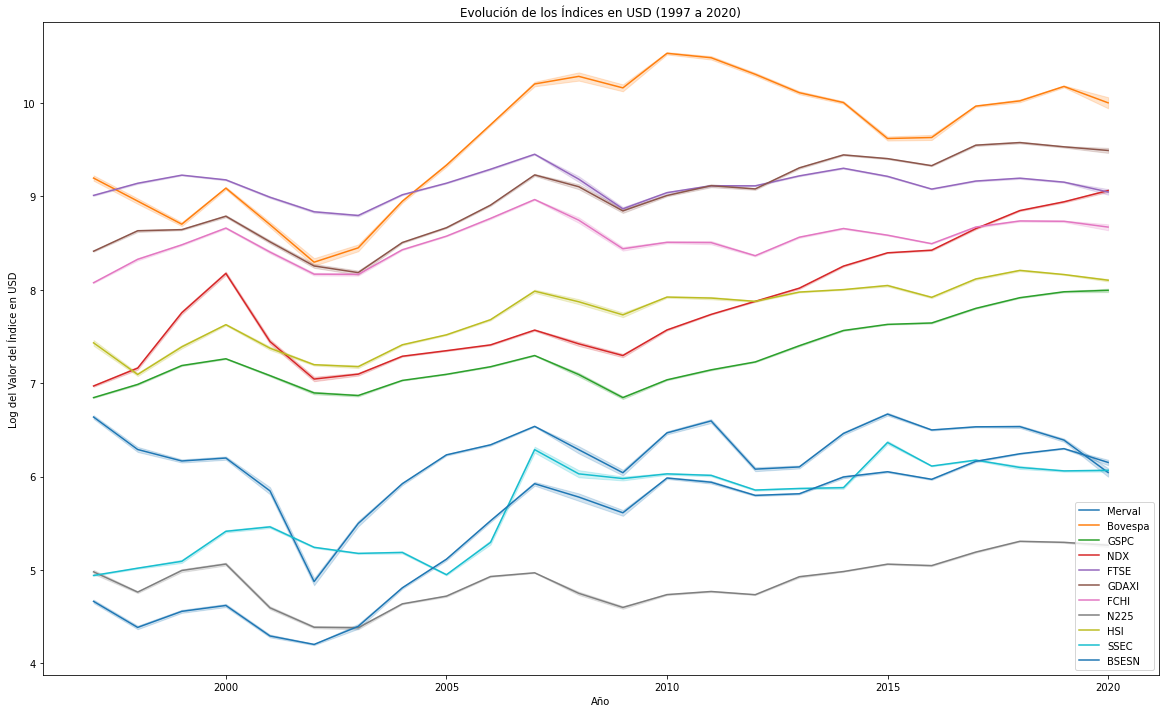

In [ ]:
df_ln = df_usd.copy()

df_ln['MERV'] = np.log(df_usd['MERV'])
df_ln['BVSP'] = np.log(df_usd['BVSP'])
df_ln['GSPC'] = np.log(df2['GSPC'])
df_ln['NDX'] = np.log(df2['NDX'])
df_ln['FTSE'] = np.log(df_usd['FTSE'])
df_ln['GDAXI'] = np.log(df_usd['GDAXI'])
df_ln['FCHI'] = np.log(df_usd['FCHI'])
df_ln['N225'] = np.log(df_usd['N225'])
df_ln['HSI'] = np.log(df_usd['HSI'])
df_ln['SSEC'] = np.log(df_usd['SSEC'])
df_ln['BSESN'] = np.log(df_usd['BSESN'])


plt.figure(figsize=(20,12))

sb.lineplot(data = df_ln, x= 'Year', y='MERV', label = "Merval")
sb.lineplot(data = df_ln, x= 'Year', y='BVSP', label = "Bovespa")
sb.lineplot(data = df_ln, x= 'Year', y='GSPC', label = "GSPC")
sb.lineplot(data = df_ln, x= 'Year', y='NDX', label = "NDX")
sb.lineplot(data = df_ln, x= 'Year', y='FTSE', label = "FTSE")
sb.lineplot(data = df_ln, x= 'Year', y='GDAXI', label = "GDAXI")
sb.lineplot(data = df_ln, x= 'Year', y='FCHI', label = "FCHI")
sb.lineplot(data = df_ln, x= 'Year', y='N225', label = "N225")
sb.lineplot(data = df_ln, x= 'Year', y='HSI', label = "HSI")
sb.lineplot(data = df_ln, x= 'Year', y='SSEC', label = "SSEC")
sb.lineplot(data = df_ln, x= 'Year', y='BSESN', label = "BSESN")
plt.title('Evolución de los Índices en USD (1997 a 2020)')
plt.xlabel('Año')
plt.ylabel('Log del Valor del Índice en USD')
plt.legend()

## Rendimiento Diario ##

In [ ]:
# Rendimiento de los índices en dólares

df_rend = df_usd.copy()

# Atraso todos los índices un periodo

df_rend['MERV1'] = df_usd[['MERV']].shift(periods=1, axis=0)
df_rend['BVSP1'] = df_usd[['BVSP']].shift(periods=1, axis=0)
df_rend['GSPC1'] = df_usd[['GSPC']].shift(periods=1, axis=0)
df_rend['NDX1'] = df_usd[['NDX']].shift(periods=1, axis=0)
df_rend['FTSE1'] = df_usd[['FTSE']].shift(periods=1, axis=0)
df_rend['GDAXI1'] = df_usd[['GDAXI']].shift(periods=1, axis=0)
df_rend['FCHI1'] = df_usd[['FCHI']].shift(periods=1, axis=0)
df_rend['N2251'] = df_usd[['N225']].shift(periods=1, axis=0)
df_rend['HSI1'] = df_usd[['HSI']].shift(periods=1, axis=0)
df_rend['SSEC1'] = df_usd[['SSEC']].shift(periods=1, axis=0)
df_rend['BSESN1'] = df_usd[['BSESN']].shift(periods=1, axis=0)

# Rendimiento diario en dólares de cada índice

df_rend['MERV_diario'] = ((df_rend.MERV - df_rend.MERV1) / df_rend.MERV1) * 100
df_rend['BVSP_diario'] = ((df_rend.BVSP - df_rend.BVSP1) / df_rend.BVSP1) * 100
df_rend['GSPC_diario'] = ((df_rend.GSPC - df_rend.GSPC1) / df_rend.GSPC1) * 100
df_rend['NDX_diario'] = ((df_rend.NDX - df_rend.NDX1) / df_rend.NDX1) * 100
df_rend['FTSE_diario'] = ((df_rend.FTSE - df_rend.FTSE1) / df_rend.FTSE1) * 100
df_rend['GDAXI_diario'] = ((df_rend.GDAXI - df_rend.GDAXI1) / df_rend.GDAXI1) * 100
df_rend['FCHI_diario'] = ((df_rend.FCHI - df_rend.FCHI1) / df_rend.FCHI1) * 100
df_rend['N225_diario'] = ((df_rend.N225 - df_rend.N2251) / df_rend.N2251) * 100
df_rend['HSI_diario'] = ((df_rend.HSI - df_rend.HSI1) / df_rend.HSI1) * 100
df_rend['SSEC_diario'] = ((df_rend.SSEC - df_rend.SSEC1) / df_rend.SSEC1) * 100
df_rend['BSESN_diario'] = ((df_rend.BSESN - df_rend.BSESN1) / df_rend.BSESN1) * 100


df_rend_diario = df_rend.drop(['MERV','BVSP','GSPC','NDX','FTSE','GDAXI','FCHI','N225','HSI','SSEC','BSESN','Month',
                               'MERV1','BVSP1','GSPC1','NDX1','FTSE1','GDAXI1','HSI1','FCHI1','N2251','SSEC1','BSESN1'], axis=1)
df_rend_diario

,Year,Weekday,MERV_diario,BVSP_diario,GSPC_diario,NDX_diario,FTSE_diario,GDAXI_diario,FCHI_diario,N225_diario,HSI_diario,SSEC_diario,BSESN_diario
FECHA,,,,,,,,,,,,,
1997-07-02,1997,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-03,1997,Thursday,0.929826,0.086285,1.425833,1.085122,3.001574,2.039279,1.116075,0.559379,-1.485951,-4.044444,-0.213017
1997-07-04,1997,Friday,0.772897,-31.055785,-0.131839,0.114093,3.187888,0.070745,-0.191773,-0.811322,-1.866134,-2.074027,-1.008059
1997-07-07,1997,Monday,0.416186,47.400318,-0.383430,0.343687,-3.596321,1.398478,0.414040,-0.513522,0.589664,-2.661495,0.186433
1997-07-08,1997,Tuesday,0.541217,0.748911,0.718043,1.490356,-0.997135,0.255689,-1.014525,0.611764,-0.457160,1.170353,0.404193
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04,2020,Monday,-2.086914,-40.541690,0.129283,0.435721,-12.974348,-15.610702,-15.750551,-0.070330,-0.420976,-13.943559,-1.592417
2020-05-05,2020,Tuesday,3.579307,0.919184,0.904056,1.092467,1.816908,1.870420,1.757611,0.328444,1.076674,0.104918,-0.864913
2020-05-06,2020,Wednesday,0.007127,-2.570277,-0.697941,0.607351,-0.744739,-1.559158,-1.520238,0.471099,1.144511,-0.470795,0.698436


Se puede graficar la distribución de los rendimientos diarios de cada índice y se ve cómo la misma se aproxima a la distribución de una serie normal con largas colas a ambos lados (especialmente para los índices más volátiles y de monedas más debiles o cambiantes, como el MERVAL). El motivo por el cual las colas son tan largas es la presencia de una gran cantidad de outliers, es decir, días en los que por alguna u otra razón la bolsa de ese país cayó estrepitosamente o vio un alza significativa, ya sea por recuperación de la pérdida anterior o por crecimiento. 

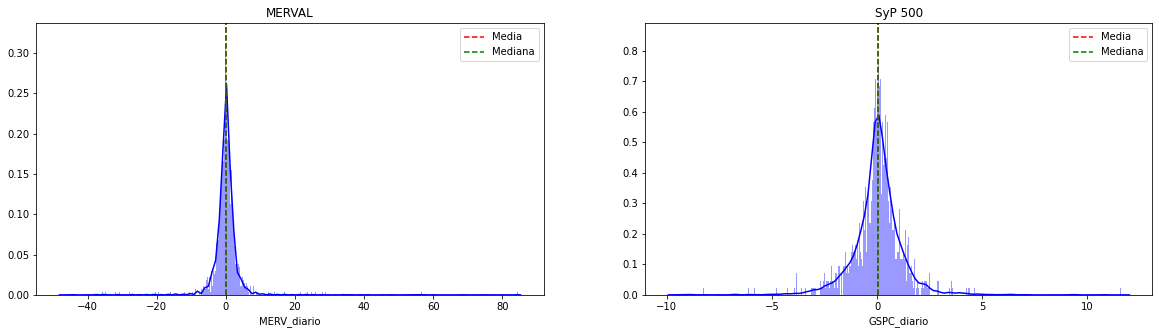

In [ ]:
plt.figure(figsize= (20,5))

plt.subplot(121)
sb.distplot(df_rend_diario.MERV_diario, kde= True, bins= 3000, color ="blue")
plt.axvline(df_rend_diario.MERV_diario.mean(), color = "red", linestyle = 'dashed', linewidth= 1.5, label = 'Media')
plt.axvline(df_rend_diario.MERV_diario.median(), color = "green", linestyle = 'dashed', linewidth= 1.5, label = 'Mediana')
plt.title('MERVAL')
plt.legend()

plt.subplot(122)
sb.distplot(df_rend_diario.GSPC_diario, kde= True, bins= 3000, color ="blue")
plt.axvline(df_rend_diario.GSPC_diario.mean(), color = "red", linestyle = 'dashed', linewidth= 1.5, label = 'Media')
plt.axvline(df_rend_diario.GSPC_diario.median(), color = "green", linestyle = 'dashed', linewidth= 1.5, label = 'Mediana')
plt.title('SyP 500')
plt.legend()


En el siguiente gráfico se representa el rendimiento diario al cierre de cada día de operación del Merval en el 2020. Llama la atención no la intermitencia entre rendimientos positivos y negativos, sino su magnitud. Se puede apreciar el efecto negativo del anuncio de la cuarentena obligatoria debido a la pandemia mundial a mediados del mes de Marzo.

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 <a list of 128 Text major ticklabel objects>)

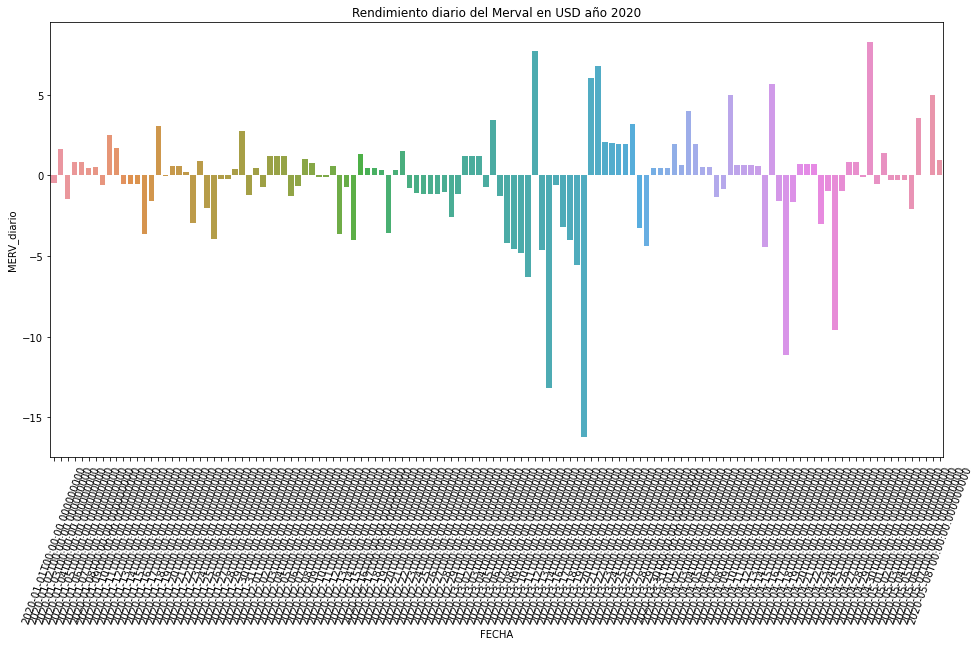

In [ ]:
# Gráfico del rendimiento diario del Merval en el 2020

merval = df_rend_diario.iloc[:, [0,2]]
merval = merval[merval['Year'] == 2020]

plt.figure(figsize= (16,8))
sb.barplot(data = merval, x = merval.index, y = 'MERV_diario')
plt.title('Rendimiento diario del Merval en USD año 2020')
plt.xticks(rotation= 70)



El siguiente cuadro muestra las mayores subas y caídas que se produjeron en cada uno de los índices, junto con el dia con que dichos movimientos se produjeron. En el caso de Argentina, tanto la mayor subida como la peor baja se preodujeron al principio del nuevo milenio, cuando se estaba produciendo la caótica salida de la convertibilidad.

In [ ]:
df1 = pd.DataFrame({
    "Media" : df_rend_diario[['MERV_diario','BVSP_diario', 'GSPC_diario', 'NDX_diario',"FTSE_diario","GDAXI_diario","FCHI_diario","N225_diario","HSI_diario","SSEC_diario","BSESN_diario"]].mean(),
    "Máximo" : df_rend_diario[['MERV_diario','BVSP_diario', 'GSPC_diario', 'NDX_diario',"FTSE_diario","GDAXI_diario","FCHI_diario","N225_diario","HSI_diario","SSEC_diario","BSESN_diario"]].max(),
    "Fecha_Máximo" : [df_rend_diario.MERV_diario.idxmax(),
             df_rend_diario.BVSP_diario.idxmax(),
             df_rend_diario.GSPC_diario.idxmax(),
             df_rend_diario.NDX_diario.idxmax(),
             df_rend_diario.FTSE_diario.idxmax(),
             df_rend_diario.GDAXI_diario.idxmax(),
             df_rend_diario.FCHI_diario.idxmax(),
             df_rend_diario.N225_diario.idxmax(),
             df_rend_diario.HSI_diario.idxmax(),
             df_rend_diario.SSEC_diario.idxmax(),
             df_rend_diario.BSESN_diario.idxmax(),
             ],
    "Mínimo" : df_rend_diario[['MERV_diario','BVSP_diario', 'GSPC_diario', 'NDX_diario',"FTSE_diario","GDAXI_diario","FCHI_diario","N225_diario","HSI_diario","SSEC_diario","BSESN_diario"]].min(),
    "Fecha_Mínimo" : [df_rend_diario.MERV_diario.idxmin(),
             df_rend_diario.BVSP_diario.idxmin(),
             df_rend_diario.GSPC_diario.idxmin(),
             df_rend_diario.NDX_diario.idxmin(),
             df_rend_diario.FTSE_diario.idxmin(),
             df_rend_diario.GDAXI_diario.idxmin(),
             df_rend_diario.FCHI_diario.idxmin(),
             df_rend_diario.N225_diario.idxmin(),
             df_rend_diario.HSI_diario.idxmin(),
             df_rend_diario.SSEC_diario.idxmin(),
             df_rend_diario.BSESN_diario.idxmin(),
             ]
})
df1



,Media,Máximo,Fecha_Máximo,Mínimo,Fecha_Mínimo
MERV_diario,0.080241,84.433345,2002-01-02,-47.223192,2001-12-04
BVSP_diario,0.366365,88.418836,2002-10-14,-48.020545,2002-10-15
GSPC_diario,0.026675,11.580037,2008-10-13,-9.511268,2020-03-12
NDX_diario,0.052411,18.771308,2001-01-03,-10.519486,2008-09-29
FTSE_diario,0.054877,29.793658,2007-11-13,-22.928672,2007-11-12
GDAXI_diario,0.042178,20.685533,2020-04-04,-16.802759,2020-03-23
FCHI_diario,0.031896,20.232282,2020-04-04,-17.155609,2020-03-23
N225_diario,0.012127,12.323424,1998-10-07,-10.515670,2008-10-16
HSI_diario,0.019371,18.885079,1997-10-29,-13.745070,1997-10-28
SSEC_diario,0.054432,17.456400,2019-09-01,-15.103679,2020-03-23


Un comentario adicional que se puede hacer respecto a la distribución diaria de los índices es que todos tienen un rendimiento diario promedio cercano a cero. Esto quiere decir que si una persona quisiera invertir en el mercado durante sólo un dia, entrando en el momento de apertura y vendiendo su posicion al cierre, no hay ningun índice para el cual pueda esperar irse con un rendimiento considerable.

## Rendimiento Mensual ##

In [ ]:
# Valores al cierre de cada mes

rend_mensual = df_usd.asfreq('M', method='ffill')

# Atraso todos los indices un periodo

rend_mensual['MERV1'] = rend_mensual[['MERV']].shift(periods=1, axis=0)
rend_mensual['BVSP1'] = rend_mensual[['BVSP']].shift(periods=1, axis=0)
rend_mensual['GSPC1'] = rend_mensual[['GSPC']].shift(periods=1, axis=0)
rend_mensual['NDX1'] = rend_mensual[['NDX']].shift(periods=1, axis=0)
rend_mensual['FTSE1'] = rend_mensual[['FTSE']].shift(periods=1, axis=0)
rend_mensual['GDAXI1'] = rend_mensual[['GDAXI']].shift(periods=1, axis=0)
rend_mensual['FCHI1'] = rend_mensual[['FCHI']].shift(periods=1, axis=0)
rend_mensual['N2251'] = rend_mensual[['N225']].shift(periods=1, axis=0)
rend_mensual['HSI1'] = rend_mensual[['HSI']].shift(periods=1, axis=0)
rend_mensual['SSEC1'] = rend_mensual[['SSEC']].shift(periods=1, axis=0)
rend_mensual['BSESN1'] = rend_mensual[['BSESN']].shift(periods=1, axis=0)

# Rendimiento mensual en dólares de cada índice

rend_mensual['MERV_mensual'] = ((rend_mensual.MERV - rend_mensual.MERV1) / rend_mensual.MERV1) * 100
rend_mensual['BVSP_mensual'] = ((rend_mensual.BVSP - rend_mensual.BVSP1) / rend_mensual.BVSP1) * 100
rend_mensual['GSPC_mensual'] = ((rend_mensual.GSPC - rend_mensual.GSPC1) / rend_mensual.GSPC1) * 100
rend_mensual['NDX_mensual'] = ((rend_mensual.NDX - rend_mensual.NDX1) / rend_mensual.NDX1) * 100
rend_mensual['FTSE_mensual'] = ((rend_mensual.FTSE - rend_mensual.FTSE1) / rend_mensual.FTSE1) * 100
rend_mensual['GDAXI_mensual'] = ((rend_mensual.GDAXI - rend_mensual.GDAXI1) / rend_mensual.GDAXI1) * 100
rend_mensual['FCHI_mensual'] = ((rend_mensual.FCHI - rend_mensual.FCHI1) / rend_mensual.FCHI1) * 100
rend_mensual['N225_mensual'] = ((rend_mensual.N225 - rend_mensual.N2251) / rend_mensual.N2251) * 100
rend_mensual['HSI_mensual'] = ((rend_mensual.HSI - rend_mensual.HSI1) / rend_mensual.HSI1) * 100
rend_mensual['SSEC_mensual'] = ((rend_mensual.SSEC - rend_mensual.SSEC1) / rend_mensual.SSEC1) * 100
rend_mensual['BSESN_mensual'] = ((rend_mensual.BSESN - rend_mensual.BSESN1) / rend_mensual.BSESN1) * 100

rend_mensual = rend_mensual.drop(['MERV','BVSP','GSPC','NDX','FTSE','GDAXI','FCHI','N225','HSI','SSEC','BSESN',
                                  'Month','MERV1','BVSP1','GSPC1','NDX1','FTSE1','GDAXI1','HSI1','FCHI1','N2251','SSEC1','BSESN1'], axis=1)

rend_mensual.loc[rend_mensual['MERV_mensual'] < 0, 'Resultado'] = 'Negativo'
rend_mensual.loc[rend_mensual['MERV_mensual'] > 0, 'Resultado'] = 'Positivo'

rend_mensual

,Year,Weekday,MERV_mensual,BVSP_mensual,GSPC_mensual,NDX_mensual,FTSE_mensual,GDAXI_mensual,FCHI_mensual,N225_mensual,HSI_mensual,SSEC_mensual,BSESN_mensual,Resultado
FECHA,,,,,,,,,,,,,,
1997-07-31,1997,Thursday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-08-31,1997,Friday,-1.952858,-18.222631,-5.746563,-2.979141,-2.942100,-9.823463,-8.706026,-12.033107,-13.707127,2.296428,-11.854618,Negativo
1997-09-30,1997,Tuesday,-1.315069,10.761690,5.315359,2.151667,8.279518,8.375366,11.018878,-1.923266,6.625050,-10.091075,1.476181,Negativo
1997-10-31,1997,Friday,-19.692601,-24.304728,-3.447770,-7.067341,-3.830928,-7.154958,-6.420269,-7.742875,-29.347339,7.583789,-3.146284,Negativo
1997-11-30,1997,Friday,-0.722644,3.929475,4.458685,3.029562,0.371659,3.967260,2.378494,-4.738515,-0.891589,-3.408945,-12.805255,Negativo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,2019,Tuesday,7.781026,13.739189,2.858982,3.919600,5.285013,2.217717,3.026184,2.025857,7.508583,7.255289,-0.236477,Positivo
2020-01-31,2020,Friday,-3.975589,-8.569827,-0.162809,2.959320,-3.938180,-3.379339,-3.894720,-1.486064,-6.383649,-7.284478,-6.140158,Negativo
2020-02-29,2020,Saturday,-12.324517,19.107192,-7.020061,-4.355661,-1.748576,5.511338,5.602030,-8.407813,-0.760398,17.660774,-5.803446,Negativo


([], <a list of 0 Text major ticklabel objects>)

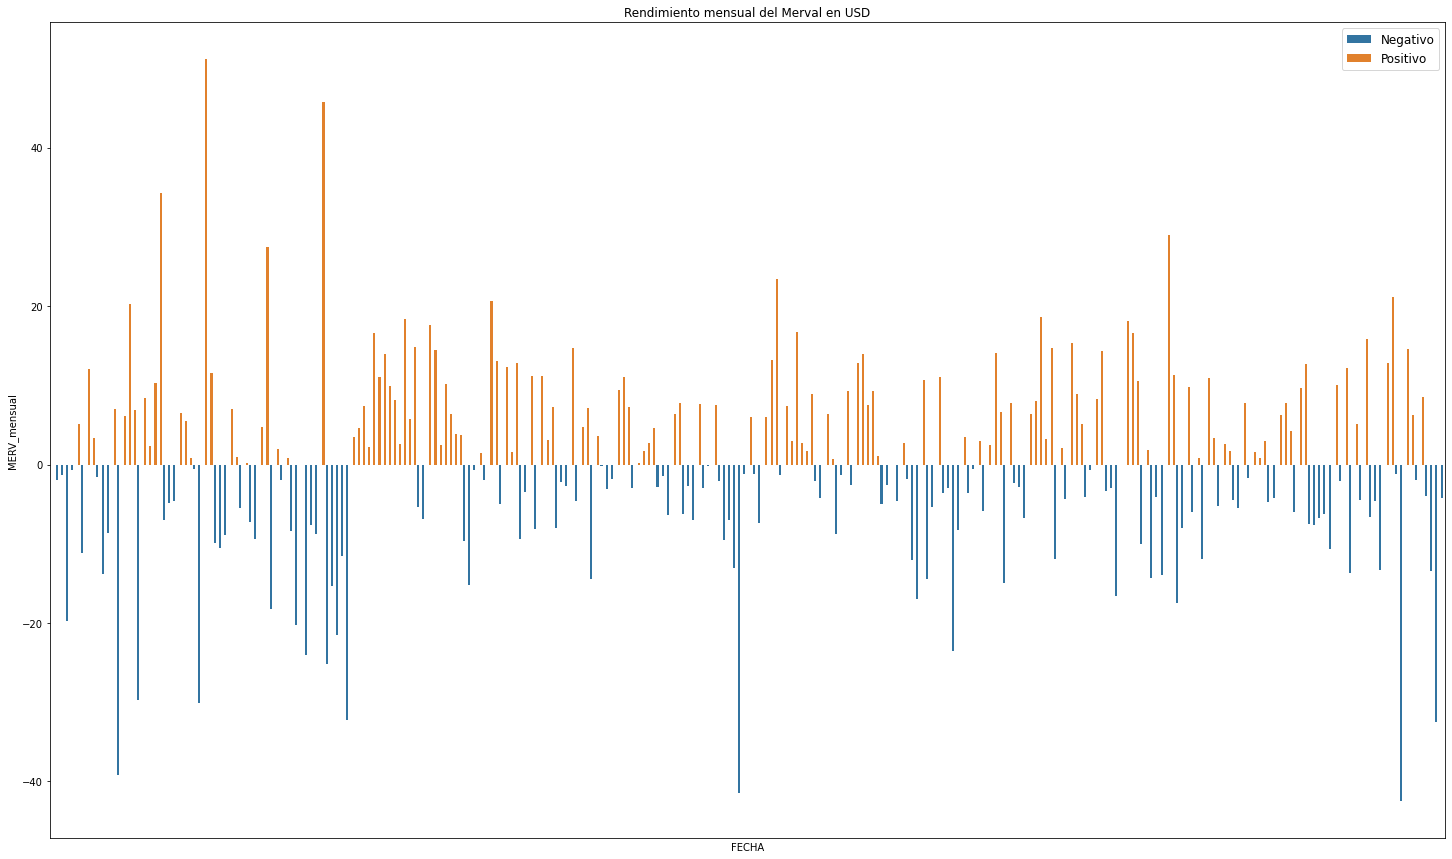

In [ ]:
plt.figure(figsize=(25,15))

sb.barplot(data = rend_mensual, x = rend_mensual.index, y = 'MERV_mensual', hue='Resultado')
plt.title('Rendimiento mensual del Merval en USD')
plt.legend(loc=1, fontsize= 'large')
plt.xticks([])

A continuación se presenta la distribucion del rendimiento mensual del MERVAL y del BOVESPA. Se puede observar cómo las colas se acortan respecto de los gráficos diarios, esto es porque al tener ahora en cuenta un período de tiempo más prolongado, los valores tan inusuales en el rendimiento, como por ejemplo 80%, tienen menos probabilidad de ocurrir que cuando sólo se considera un día de operación. 

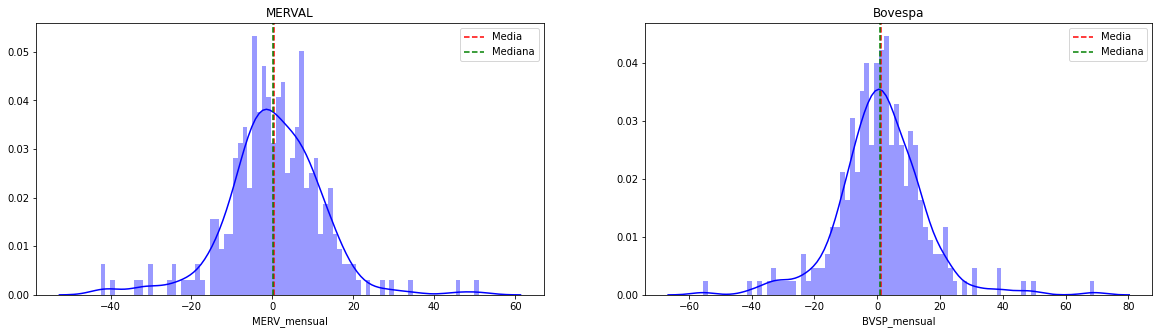

In [ ]:
plt.figure(figsize= (20,5))

plt.subplot(121)
sb.distplot(rend_mensual.MERV_mensual, kde= True, bins= 80, color ="blue")
plt.axvline(rend_mensual.MERV_mensual.mean(), color = "red", linestyle = 'dashed', linewidth= 1.5, label = 'Media')
plt.axvline(rend_mensual.MERV_mensual.median(), color = "green", linestyle = 'dashed', linewidth= 1.5, label = 'Mediana')
plt.title('MERVAL')
plt.legend()

plt.subplot(122)
sb.distplot(rend_mensual.BVSP_mensual, kde= True, bins= 80, color ="blue")
plt.axvline(rend_mensual.BVSP_mensual.mean(), color = "red", linestyle = 'dashed', linewidth= 1.5, label = 'Media')
plt.axvline(rend_mensual.BVSP_mensual.median(), color = "green", linestyle = 'dashed', linewidth= 1.5, label = 'Mediana')
plt.title('Bovespa')
plt.legend()

In [ ]:
tabla = pd.DataFrame({
    "Media" : rend_mensual[['MERV_mensual','BVSP_mensual', 'GSPC_mensual', 'NDX_mensual',"FTSE_mensual","GDAXI_mensual","FCHI_mensual","N225_mensual","HSI_mensual","SSEC_mensual","BSESN_mensual"]].mean(),
    "Máximo" : rend_mensual[['MERV_mensual','BVSP_mensual', 'GSPC_mensual', 'NDX_mensual',"FTSE_mensual","GDAXI_mensual","FCHI_mensual","N225_mensual","HSI_mensual","SSEC_mensual","BSESN_mensual"]].max(),
    "Fecha_Máximo" : [rend_mensual.MERV_mensual.idxmax(),
             rend_mensual.BVSP_mensual.idxmax(),
             rend_mensual.GSPC_mensual.idxmax(),
             rend_mensual.NDX_mensual.idxmax(),
             rend_mensual.FTSE_mensual.idxmax(),
             rend_mensual.GDAXI_mensual.idxmax(),
             rend_mensual.FCHI_mensual.idxmax(),
             rend_mensual.N225_mensual.idxmax(),
             rend_mensual.HSI_mensual.idxmax(),
             rend_mensual.SSEC_mensual.idxmax(),
             rend_mensual.BSESN_mensual.idxmax(),
             ],
    "Mínimo" : rend_mensual[['MERV_mensual','BVSP_mensual', 'GSPC_mensual', 'NDX_mensual',"FTSE_mensual","GDAXI_mensual","FCHI_mensual","N225_mensual","HSI_mensual","SSEC_mensual","BSESN_mensual"]].min(),
    "Fecha_Mínimo" : [rend_mensual.MERV_mensual.idxmin(),
             rend_mensual.BVSP_mensual.idxmin(),
             rend_mensual.GSPC_mensual.idxmin(),
             rend_mensual.NDX_mensual.idxmin(),
             rend_mensual.FTSE_mensual.idxmin(),
             rend_mensual.GDAXI_mensual.idxmin(),
             rend_mensual.FCHI_mensual.idxmin(),
             rend_mensual.N225_mensual.idxmin(),
             rend_mensual.HSI_mensual.idxmin(),
             rend_mensual.SSEC_mensual.idxmin(),
             rend_mensual.BSESN_mensual.idxmin(),
             ]
})
tabla

,Media,Máximo,Fecha_Máximo,Mínimo,Fecha_Mínimo
MERV_mensual,0.360942,51.119907,2000-01-31,-42.429463,2019-08-31
BVSP_mensual,1.086429,69.183587,2012-01-31,-55.519084,2020-03-31
GSPC_mensual,0.509072,12.684404,2020-04-30,-16.942452,2008-10-31
NDX_mensual,1.034727,24.981212,1999-12-31,-26.404938,2001-02-28
FTSE_mensual,0.095635,13.678979,2009-05-31,-25.216176,2020-03-31
GDAXI_mensual,0.595139,24.255571,2003-04-30,-27.874044,2020-03-31
FCHI_mensual,0.364080,18.011092,2015-02-28,-28.711159,2020-03-31
N225_mensual,0.180844,18.678398,1998-10-31,-17.889965,2008-10-31
HSI_mensual,0.383293,28.874777,1998-10-31,-29.347339,1997-10-31
SSEC_mensual,0.704201,33.259221,1999-06-30,-23.794572,2016-01-31


## Rendimiento Anual

In [ ]:
# Rendimiento anual de cada índice

# Valores al cierre de cada año

rend_anual = df_usd.asfreq('Y', method='ffill')

# Atraso todos los indices un periodo

rend_anual['MERV1'] = rend_anual[['MERV']].shift(periods=1, axis=0)
rend_anual['BVSP1'] = rend_anual[['BVSP']].shift(periods=1, axis=0)
rend_anual['GSPC1'] = rend_anual[['GSPC']].shift(periods=1, axis=0)
rend_anual['NDX1'] = rend_anual[['NDX']].shift(periods=1, axis=0)
rend_anual['FTSE1'] = rend_anual[['FTSE']].shift(periods=1, axis=0)
rend_anual['GDAXI1'] = rend_anual[['GDAXI']].shift(periods=1, axis=0)
rend_anual['FCHI1'] = rend_anual[['FCHI']].shift(periods=1, axis=0)
rend_anual['N2251'] = rend_anual[['N225']].shift(periods=1, axis=0)
rend_anual['HSI1'] = rend_anual[['HSI']].shift(periods=1, axis=0)
rend_anual['SSEC1'] = rend_anual[['SSEC']].shift(periods=1, axis=0)
rend_anual['BSESN1'] = rend_anual[['BSESN']].shift(periods=1, axis=0)

# Rendimiento anual en dólares de cada índice

rend_anual['MERV_anual'] = ((rend_anual.MERV - rend_anual.MERV1) / rend_anual.MERV1) * 100
rend_anual['BVSP_anual'] = ((rend_anual.BVSP - rend_anual.BVSP1) / rend_anual.BVSP1) * 100
rend_anual['GSPC_anual'] = ((rend_anual.GSPC - rend_anual.GSPC1) / rend_anual.GSPC1) * 100
rend_anual['NDX_anual'] = ((rend_anual.NDX - rend_anual.NDX1) / rend_anual.NDX1) * 100
rend_anual['FTSE_anual'] = ((rend_anual.FTSE - rend_anual.FTSE1) / rend_anual.FTSE1) * 100
rend_anual['GDAXI_anual'] = ((rend_anual.GDAXI - rend_anual.GDAXI1) / rend_anual.GDAXI1) * 100
rend_anual['FCHI_anual'] = ((rend_anual.FCHI - rend_anual.FCHI1) / rend_anual.FCHI1) * 100
rend_anual['N225_anual'] = ((rend_anual.N225 - rend_anual.N2251) / rend_anual.N2251) * 100
rend_anual['HSI_anual'] = ((rend_anual.HSI - rend_anual.HSI1) / rend_anual.HSI1) * 100
rend_anual['SSEC_anual'] = ((rend_anual.SSEC - rend_anual.SSEC1) / rend_anual.SSEC1) * 100
rend_anual['BSESN_anual'] = ((rend_anual.BSESN - rend_anual.BSESN1) / rend_anual.BSESN1) * 100

rend_anual = rend_anual.drop(['MERV','BVSP','GSPC','NDX','FTSE','GDAXI','FCHI','N225','HSI','SSEC','BSESN',
                                  'Month','MERV1','BVSP1','GSPC1','NDX1','FTSE1','GDAXI1','HSI1','FCHI1','N2251','SSEC1','BSESN1'], axis=1)

rend_anual.loc[rend_anual['MERV_anual'] < 0, 'Resultado'] = 'Negativo'
rend_anual.loc[rend_anual['MERV_anual'] > 0, 'Resultado'] = 'Positivo'

rend_anual




,Year,Weekday,MERV_anual,BVSP_anual,GSPC_anual,NDX_anual,FTSE_anual,GDAXI_anual,FCHI_anual,N225_anual,HSI_anual,SSEC_anual,BSESN_anual,Resultado
FECHA,,,,,,,,,,,,,,
1997-12-31,1997,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-12-31,1998,Thursday,-50.220090,-38.815154,26.668589,85.300201,15.938802,26.447018,41.681457,4.353326,-6.264739,-3.608775,-22.819294,Negativo
1999-12-31,1999,Friday,9.147584,67.134612,19.526047,101.950428,13.555507,17.219536,28.318762,52.456746,69.236817,19.792905,63.105135,Positivo
2000-12-31,2000,Friday,11.590949,-16.844650,-10.139185,-36.844464,-16.213640,-12.861609,-6.797976,-35.000321,-11.828753,50.972427,-27.506863,Positivo
2001-12-31,2001,Monday,-28.529367,-24.100053,-13.042693,-32.653624,-18.462610,-24.108413,-26.651493,-32.372707,-24.481044,-20.610322,-20.455557,Negativo
2002-12-31,2002,Tuesday,-47.810896,-45.965475,-23.365964,-37.581563,-16.416000,-32.369928,-21.460583,-11.190786,-18.222671,-17.550593,4.105874,Negativo
2003-12-31,2003,Wednesday,134.837423,139.684720,26.380400,49.122794,25.947525,61.173536,39.201466,37.959697,35.521034,10.310970,82.188635,Positivo
2004-12-31,2004,Friday,26.298297,27.477814,8.993452,10.436532,15.480251,15.276925,15.675233,12.066987,13.032846,-15.397678,19.038348,Positivo
2005-12-31,2005,Friday,10.184452,45.994762,3.001023,1.485390,4.698454,10.779568,7.788832,22.093247,4.797885,-5.981809,37.015117,Positivo


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text major ticklabel objects>)

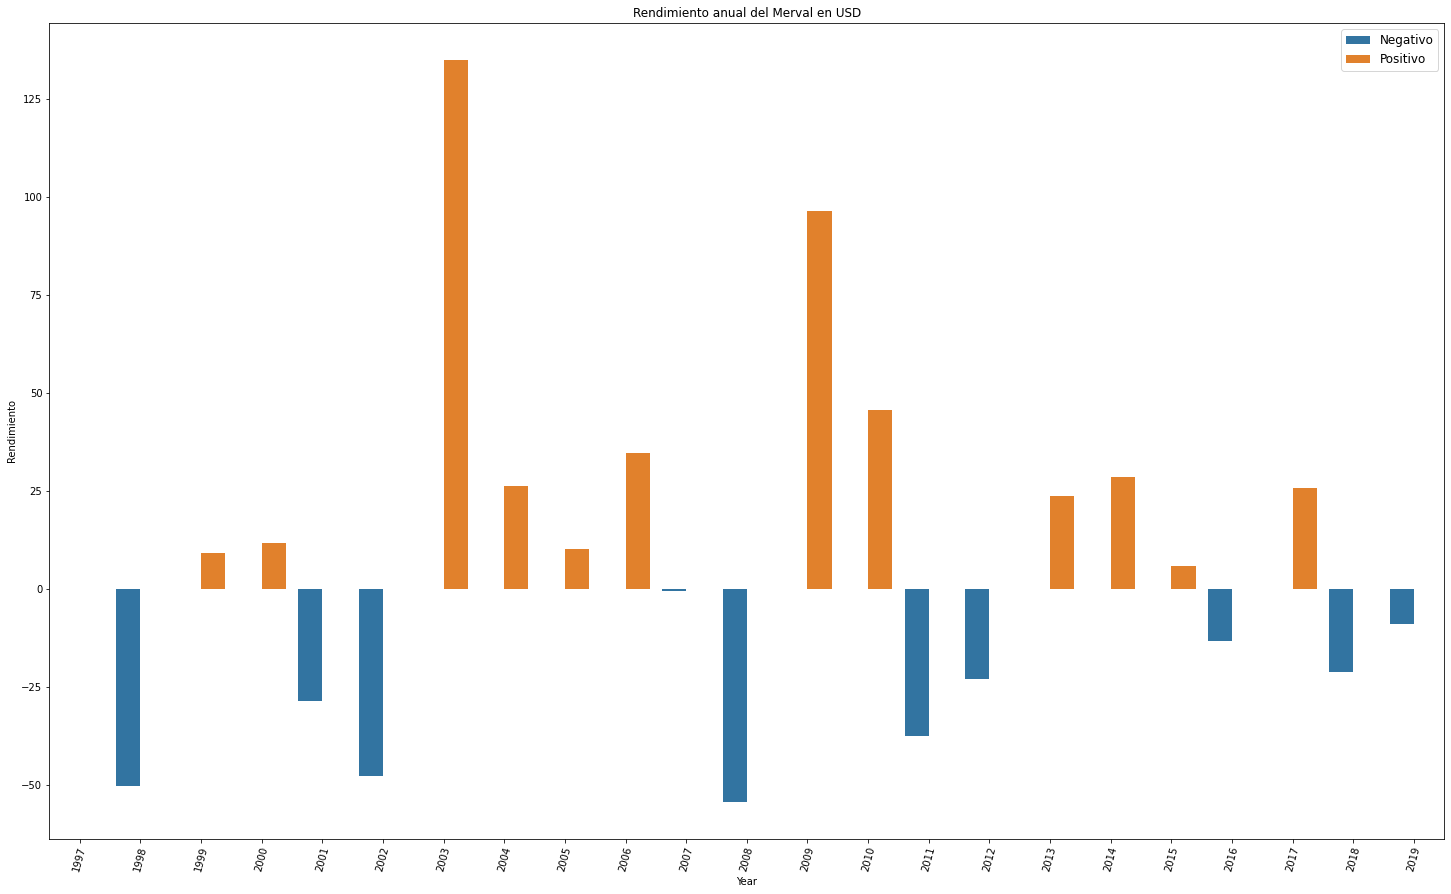

In [ ]:
plt.figure(figsize=(25,15))

sb.barplot(data = rend_anual, x = 'Year', y = 'MERV_anual', hue='Resultado')
plt.title('Rendimiento anual del Merval en USD')
plt.legend(loc=1, fontsize= 'large')
plt.ylabel('Rendimiento')
plt.xticks(rotation=75)

In [ ]:
tabla2 = pd.DataFrame({
    "Media" : rend_anual[['MERV_anual','BVSP_anual', 'GSPC_anual', 'NDX_anual',"FTSE_anual","GDAXI_anual","FCHI_anual","N225_anual","HSI_anual","SSEC_anual","BSESN_anual"]].mean(),
    "Mediana" : rend_anual[['MERV_anual','BVSP_anual', 'GSPC_anual', 'NDX_anual',"FTSE_anual","GDAXI_anual","FCHI_anual","N225_anual","HSI_anual","SSEC_anual","BSESN_anual"]].median(),
    "Máximo" : rend_anual[['MERV_anual','BVSP_anual', 'GSPC_anual', 'NDX_anual',"FTSE_anual","GDAXI_anual","FCHI_anual","N225_anual","HSI_anual","SSEC_anual","BSESN_anual"]].max(),
    "Mínimo" : rend_anual[['MERV_anual','BVSP_anual', 'GSPC_anual', 'NDX_anual',"FTSE_anual","GDAXI_anual","FCHI_anual","N225_anual","HSI_anual","SSEC_anual","BSESN_anual"]].min(),
})
tabla2

,Media,Mediana,Máximo,Mínimo
MERV_anual,7.590085,7.478758,134.837423,-54.239974
BVSP_anual,17.316146,12.605802,139.684720,-53.241717
GSPC_anual,7.187923,10.462828,29.601250,-38.485793
NDX_anual,16.031043,13.345012,101.950428,-41.885336
FTSE_anual,2.820287,4.851210,34.687522,-49.121456
GDAXI_anual,8.775498,13.028247,61.173536,-41.710668
FCHI_anual,6.105899,9.885023,41.681457,-45.076872
N225_anual,5.152133,6.979744,52.456746,-35.000321
HSI_anual,7.935205,3.044869,69.236817,-47.946279
SSEC_anual,13.608692,0.595166,138.290591,-63.047319


## Rendimiento Acumulado

In [ ]:
# Rendimiento acumulado de cada índice

df3 = df_usd.copy()


df3['MERV_acum'] = ((df_rend.MERV - df_usd.loc['1997-07-02', 'MERV']) / df_usd.loc['1997-07-02', 'MERV']) * 100
df3['BVSP_acum'] = ((df_rend.BVSP - df_usd.loc['1997-07-02', 'BVSP']) / df_usd.loc['1997-07-02', 'BVSP']) * 100
df3['GSPC_acum'] = ((df_rend.GSPC - df_usd.loc['1997-07-02', 'GSPC']) / df_usd.loc['1997-07-02', 'GSPC']) * 100
df3['NDX_acum'] = ((df_rend.NDX - df_usd.loc['1997-07-02', 'NDX']) / df_usd.loc['1997-07-02', 'NDX']) * 100
df3['FTSE_acum'] = ((df_rend.FTSE - df_usd.loc['1997-07-02', 'FTSE']) / df_usd.loc['1997-07-02', 'FTSE']) * 100
df3['GDAXI_acum'] = ((df_rend.GDAXI - df_usd.loc['1997-07-02', 'GDAXI']) / df_usd.loc['1997-07-02', 'GDAXI']) * 100
df3['FCHI_acum'] = ((df_rend.FCHI - df_usd.loc['1997-07-02', 'FCHI']) / df_usd.loc['1997-07-02', 'FCHI']) * 100
df3['N225_acum'] = ((df_rend.N225 - df_usd.loc['1997-07-02', 'N225']) / df_usd.loc['1997-07-02', 'N225']) * 100
df3['HSI_acum'] = ((df_rend.HSI - df_usd.loc['1997-07-02', 'HSI']) / df_usd.loc['1997-07-02', 'HSI']) * 100
df3['SSEC_acum'] = ((df_rend.SSEC - df_usd.loc['1997-07-02', 'SSEC']) / df_usd.loc['1997-07-02', 'SSEC']) * 100
df3['BSESN_acum'] = ((df_rend.BSESN - df_usd.loc['1997-07-02', 'BSESN']) / df_usd.loc['1997-07-02', 'BSESN']) * 100

df3

,MERV,BVSP,GSPC,NDX,FTSE,GDAXI,FCHI,N225,HSI,SSEC,BSESN,Year,Month,Weekday,MERV_acum,BVSP_acum,GSPC_acum,NDX_acum,FTSE_acum,GDAXI_acum,FCHI_acum,N225_acum,HSI_acum,SSEC_acum,BSESN_acum
FECHA,,,,,,,,,,,,,,,,,,,,,,,,,
1997-07-02,824.274840,12315.408192,904.030029,975.929993,7920.583637,4340.528952,3265.331850,176.357142,1973.374013,144.100469,121.058656,1997,7,Wednesday,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-07-03,831.939165,12326.034515,916.919983,986.520020,8158.325779,4429.044444,3301.775400,177.343647,1944.050642,138.272406,120.800781,1997,7,Thursday,0.929826,0.086285,1.425833,1.085122,3.001574,2.039279,1.116075,0.559379,-1.485951,-4.044444,-0.213017
1997-07-04,838.369197,8498.087757,915.711121,987.645566,8418.404105,4432.177768,3295.443500,175.904819,1907.772050,135.404599,119.583038,1997,7,Friday,1.709910,-30.996296,1.292113,1.200452,6.285149,2.111467,0.922162,-0.256481,-3.324355,-6.034588,-1.218929
1997-07-07,841.858374,12526.208368,912.200012,991.039978,8115.651229,4494.160820,3309.087965,175.001509,1919.021492,131.800812,119.805980,1997,7,Monday,2.133212,1.711678,0.903729,1.548265,2.462793,3.539473,1.340020,-0.768686,-2.754294,-8.535473,-1.034768
1997-07-08,846.414658,12620.018536,918.750000,1005.809998,8034.727250,4505.651910,3275.516455,176.072106,1910.248489,133.343347,120.290227,1997,7,Tuesday,2.685975,2.473408,1.628261,3.061696,1.441101,3.804213,0.311901,-0.161625,-3.198863,-7.465015,-0.634758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04,294.429812,14157.303371,2842.739990,8834.110352,7151.973158,11417.185233,4775.773262,183.930632,3045.684463,406.684889,409.692745,2020,5,Monday,-64.280141,14.956022,214.451943,805.199186,-9.703963,163.036726,46.256904,4.294405,54.338936,182.223155,238.424989
2020-05-05,304.968359,14287.435054,2868.439941,8930.620117,7281.917938,11630.734597,4859.712793,184.534740,3078.476560,407.111575,406.149258,2020,5,Tuesday,-63.001617,16.012680,217.294763,815.088191,-8.063367,167.956618,48.827532,4.636953,56.000664,182.519258,235.497907
2020-05-06,304.990095,13920.208458,2848.419922,8984.860352,7227.686619,11449.393116,4785.833584,185.404082,3113.710071,405.194915,408.985952,2020,5,Wednesday,-62.998980,13.030833,215.080233,820.645991,-8.748055,163.778752,46.564999,5.129897,57.786109,181.189172,237.841146


El Índice de mayor crecimiento en el período estudiado es por lejos el Nasdaq de tecnológicas de Estados Unidos. Se nota claramente la aceleración en el rendimiento de dicho índice especialmente a partir del año 2010, este mayor crecimiento se corresponde con el despegue de las grandes empresas tecnológicas de la actualidad que tienen mucho peso en e índice como por ejemplo Facebook, Amazon, Google y Apple.

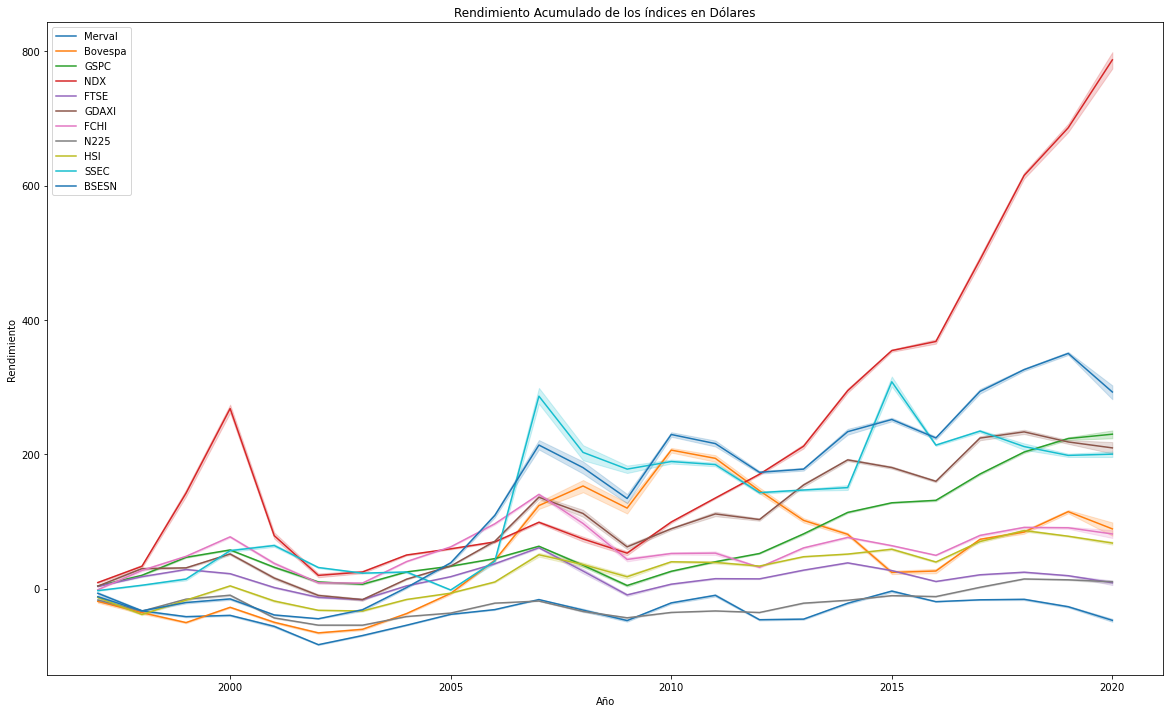

In [ ]:
plt.figure(figsize=(20,12))

sb.lineplot(data = df3, x= 'Year', y='MERV_acum', label = "Merval")
sb.lineplot(data = df3, x= 'Year', y='BVSP_acum', label = "Bovespa")
sb.lineplot(data = df3, x= 'Year', y='GSPC_acum', label = "GSPC")
sb.lineplot(data = df3, x= 'Year', y='NDX_acum', label = "NDX")
sb.lineplot(data = df3, x= 'Year', y='FTSE_acum', label = "FTSE")
sb.lineplot(data = df3, x= 'Year', y='GDAXI_acum', label = "GDAXI")
sb.lineplot(data = df3, x= 'Year', y='FCHI_acum', label = "FCHI")
sb.lineplot(data = df3, x= 'Year', y='N225_acum', label = "N225")
sb.lineplot(data = df3, x= 'Year', y='HSI_acum', label = "HSI")
sb.lineplot(data = df3, x= 'Year', y='SSEC_acum', label = "SSEC")
sb.lineplot(data = df3, x= 'Year', y='BSESN_acum', label = "BSESN")
plt.title('Rendimiento Acumulado de los índices en Dólares')
plt.xlabel('Año')
plt.ylabel('Rendimiento')
plt.legend()

Si analizamos el rendimiendo acumulado del Merval en dólares desde 1997 hasta la fecha, notamos no sólo que dicho rendimiento es negativo, sino que en ningun momento en todo ese lapso llegó a adoptar valores positivos. Esto significa que si por ejemplo una persona hubiese invertido USD 1 en el Merval en 1997, hoy tendría sólamente cerca de 60 centavos de dólar y lo que es más, en ningun momento ese dólar hubiese valido más de lo que valía al momento de invertirlo. Por supuesto que esto es considerando todo el período, y no implica que en todo este tiempo nadie haya ganado invirtiendo en el Merval, sino que aquellas personas que se hayan animado a entrar en alguno de las muchas depresiones que se observan en el gráfico y hayan tenido la habilidad de salir en alguno de los también muchos picos, lo hicieron con una rentabilidad enorme. 
En definitiva, esto quiere decir que si bien la performance del Merval durante todo el período estudiado fue la peor de todos los índices analizados, aún así el Merval otorgó muchas oportunidades de ganancias en este tiempo.

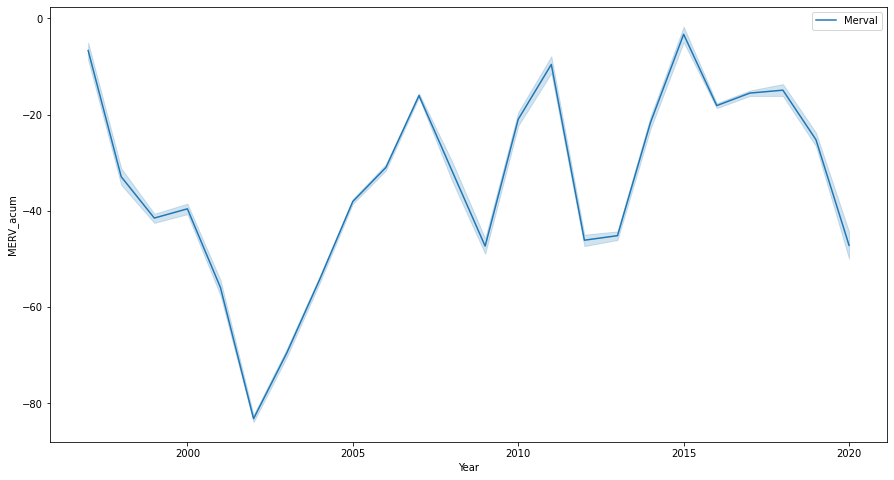

In [ ]:

plt.figure(figsize=(15,8))

sb.lineplot(data = df3, x= 'Year', y='MERV_acum', label = "Merval")

#### **Exploración de las series transformadas:**

Reutilizar parte del código del TP1 para analizar las series transformadas. En una primera etapa se puede trabajar con solo una de las series resultantes de tomar logaritmo natural y una serie de tasa de rendimiento.


*   Analizar las distribuciones por medio de gráficos y medidas de estadística descriptiva.
*   Dichas distribuciones, ¿se mantienen relativamente inalteradas en el tiempo?
*   ¿Hay outliers?
*   Estudiar la evolución temporal de las series. ¿En qué sentido tienden a moverse? ¿Tienden a moverse en forma conjunta? ¿Siempre se da dicho patrón? ¿Hay períodos de crisis? En caso de que existan crisis, ¿Son globales o propias de mercados individuales?

El análisis de la distribución de las series transformadas se fue haciendo junto con la misma transformación. 
Algo que se puede agregar respecto a la pregunta de si las series se mantienen relativamente inalteradas en el tiempo es que al menos cuando consideramos los rendimientos en dólares tanto diarios como mensuales, estas son series que si se podría decir que se mantienen inalteradas ya que tienen media cero y su varianza no parece alterarse mucho en el tiempo. Tal como se observa en el siguiente gráfico:

([], <a list of 0 Text major ticklabel objects>)

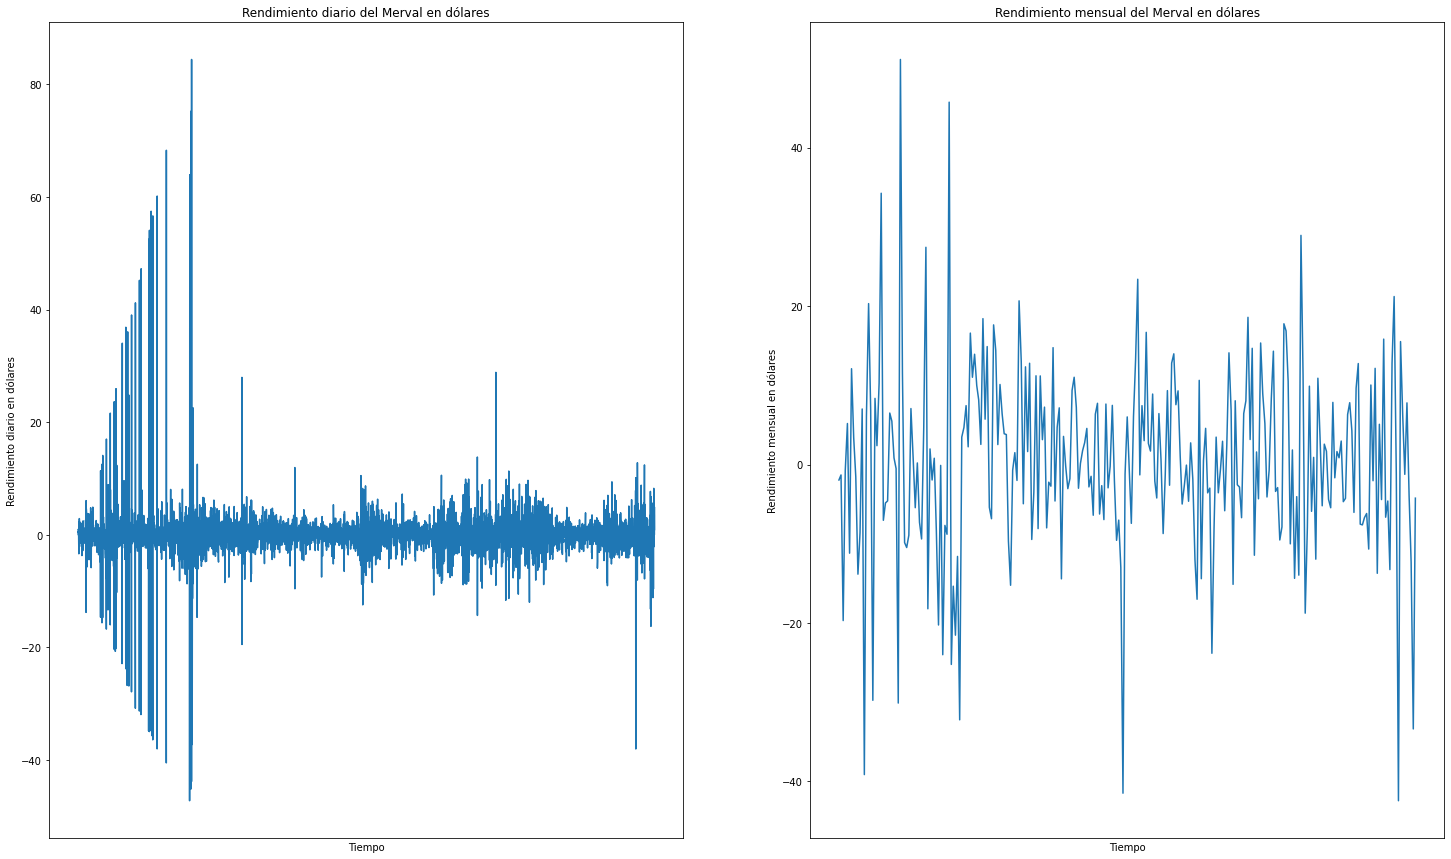

In [ ]:
plt.figure(figsize=(25,15))

plt.subplot(121)
sb.lineplot(data= df_rend_diario, x= df_rend_diario.index, y= 'MERV_diario')
plt.title('Rendimiento diario del Merval en dólares')
plt.ylabel('Rendimiento diario en dólares')
plt.xlabel('Tiempo')
plt.xticks([])

plt.subplot(122)
sb.lineplot(data= rend_mensual, x= rend_mensual.index, y= 'MERV_mensual')
plt.title('Rendimiento mensual del Merval en dólares')
plt.ylabel('Rendimiento mensual en dólares')
plt.xlabel('Tiempo')
plt.xticks([])


El siguiente gráfico de boxplot sirve tanto para confirmar que la distribución de los rendimientos se mantienen inalteradas en el tiempo como para identificar posibles outliers. 

Se puede ver calaramente los outliers del año 2001 y 2002, generados por la turbulencia económica y cambiaria que significó la salida de la Convertivilidad. Luego de eso hubo pocos meses en los que el Merval haya presentado un rendimiento demasiado fuera de lo común (comparado a sus propios estándares los cuales de por sí ya son bastante volátiles). 
Los outliers que más llaman la atencion por la magnitud de la caída son el producido en el año 2008 con motivo de la crisis financiera internacional originada en el mercado hipotecario estadounidense; y el producido en Agosto del año pasado luego del resultado de las PASO.
Ambos casos confomaron la mayor caída del Merval en el período estudiado. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

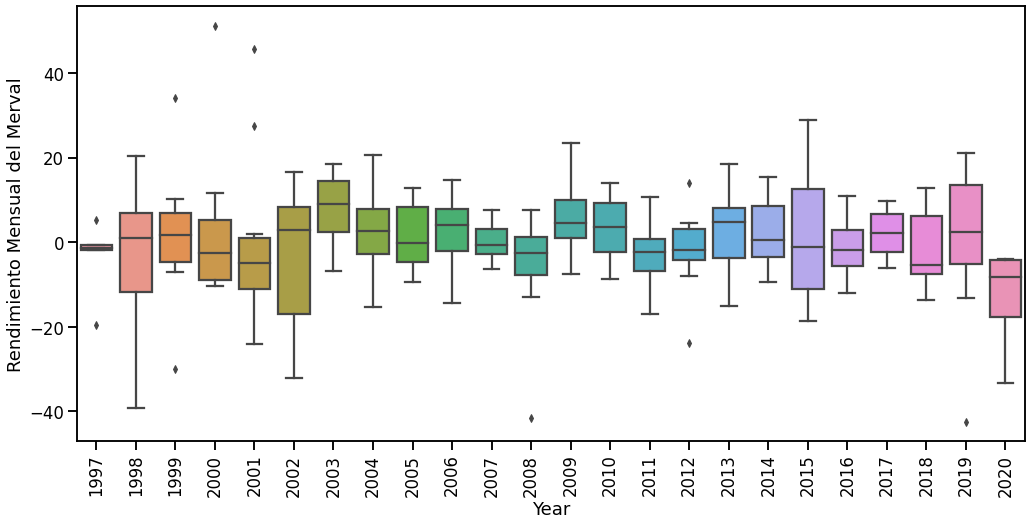

In [ ]:
plt.figure(figsize= (17,8))
sb.set_context(context="talk")

sb.boxplot(data= rend_mensual, x="Year", y="MERV_mensual")
plt.ylabel('Rendimiento Mensual del Merval')
plt.xticks(rotation=90)

El gráfico del rendimiento acumulado en dólares de cada índice es ideal para analizar el impacto de las distintas crisis financieras mundiales que se produjeron en el período analizado.

En primer lugar, se puede apreciar con claridad el elevadísimo ascenso y rápida caida del Nasdaq a principios de los 2000 generada por la famosa burbuja y crisis de las "Punto com". Los demás mercados tambien se resintieron al explotar esta burbuja pero en menor medida de lo que lo hicieron en el año 2008 tras la crisis subprime. 

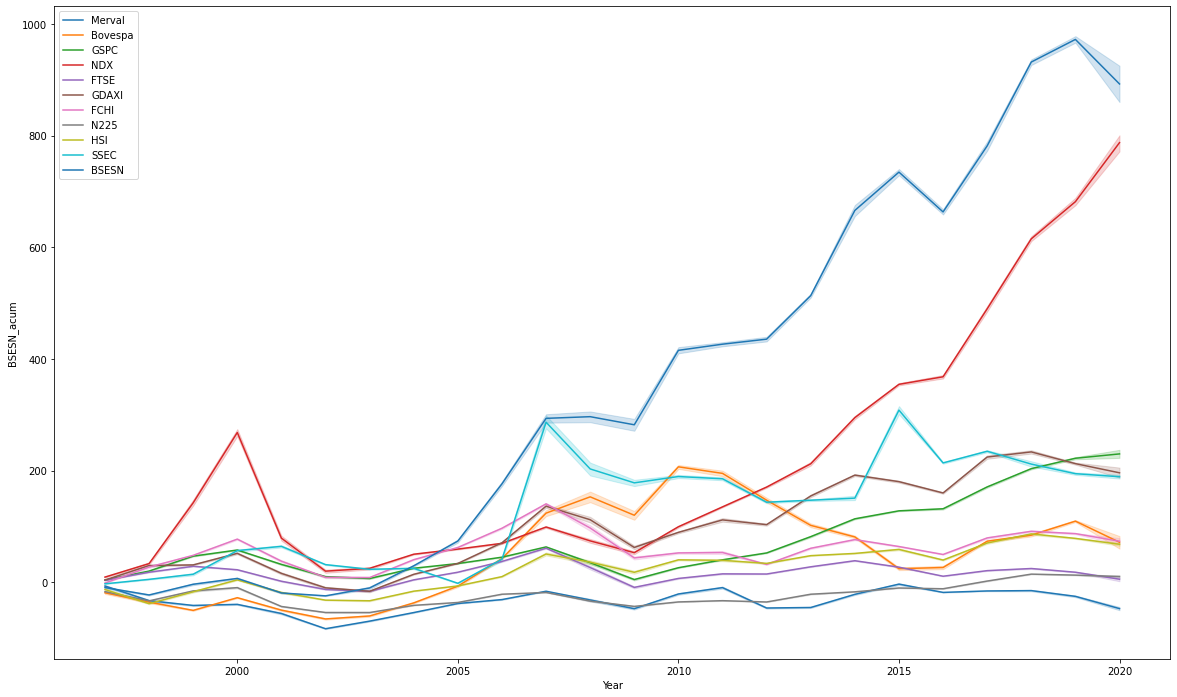

In [ ]:

plt.figure(figsize=(20,12))

sb.lineplot(data = df3, x= 'Year', y='MERV_acum', label = "Merval")
sb.lineplot(data = df3, x= 'Year', y='BVSP_acum', label = "Bovespa")
sb.lineplot(data = df3, x= 'Year', y='GSPC_acum', label = "GSPC")
sb.lineplot(data = df3, x= 'Year', y='NDX_acum', label = "NDX")
sb.lineplot(data = df3, x= 'Year', y='FTSE_acum', label = "FTSE")
sb.lineplot(data = df3, x= 'Year', y='GDAXI_acum', label = "GDAXI")
sb.lineplot(data = df3, x= 'Year', y='FCHI_acum', label = "FCHI")
sb.lineplot(data = df3, x= 'Year', y='N225_acum', label = "N225")
sb.lineplot(data = df3, x= 'Year', y='HSI_acum', label = "HSI")
sb.lineplot(data = df3, x= 'Year', y='SSEC_acum', label = "SSEC")
sb.lineplot(data = df3, x= 'Year', y='BSESN_acum', label = "BSESN")
plt.legend()

#### **Opcional:**


*   Graficar e interpretar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF).
*   Explorar la volatilidad de las series, por ejemplo graficando las desviaciones estándar móviles.